In [124]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/omichel/Desktop/qilimanjaro/projects/retech/retech_2025/src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.digital.ansatz import HardwareEfficientAnsatz
from qilisdk.optimizers import SciPyOptimizer
from qilisdk.functionals.variational_program import VariationalProgram
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.core import Model, BinaryVariable
from qilisdk.cost_functions import ModelCostFunction

In [125]:
nqubits = 3

H_test = hamiltonian.create_random_hamiltonian(nqubits, -1.0, 1.0)

psi_0 = dynamics.initialize_down_state(nqubits)

print(H_test.H)

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.40781679 -0.59245442  0.08172102  0.         -0.68698449  0.
   0.          0.        ]
 [-0.59245442 -1.68528519  0.          0.08172102  0.         -0.68698449
   0.          0.        ]
 [ 0.08172102  0.          2.03744086 -0.59245442  0.          0.
  -0.68698449  0.        ]
 [ 0.          0.08172102 -0.59245442 -0.34704449  0.          0.
   0.         -0.68698449]
 [-0.68698449  0.          0.          0.          0.00282511 -0.59245442
   0.08172102  0.        ]
 [ 0.         -0.68698449  0.          0.         -0.59245442  1.22818225
   0.          0.08172102]
 [ 0.          0.         -0.68698449  0.          0.08172102  0.
  -1.28895454 -0.59245442]
 [ 0.          0.          0.         -0.68698449  0.          0.08172102
  -0.59245442 -0.35498078]]


In [126]:
ti = 0
tf = 2
nsteps = 1000

sim = dynamics.time_evolution(H_test, psi_0, ti, tf, nsteps)

observables = dynamics.calculate_expectation_values(sim, H_test)

print(observables['Sz'][-1])
print(observables['Sx'][-1])

target_state = sim.states[-1]

analog_probabilities = dynamics.get_bitstring_probabilities(target_state, basis='Z')

print(analog_probabilities)


[-0.26858235  0.97250939  0.17313891]
[-0.65515304  0.01479858  0.58220707]
{'000': 0.25194192048450925, '001': 0.10623139905406388, '010': 0.005852230486052011, '011': 0.0016832730157982623, '100': 0.32851286330664276, '101': 0.2995685135289949, '110': 0.0002624419461321568, '111': 0.00594735817780637}


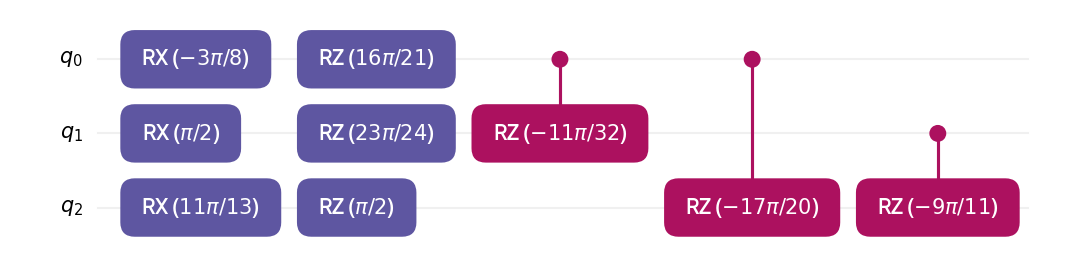

In [127]:
connectivity = VQE.generate_connectivity_list(nqubits, mode = 'ATA')

layers = 1

per_layer = 2*nqubits + len(connectivity)
params_uniform = np.random.uniform(-np.pi, np.pi, size=(layers * per_layer))
params_zero = np.zeros(layers * per_layer)

circuit = VQE.build_ansatz_circuit(params_uniform, nqubits, layers, connectivity)

circuit.draw()


In [128]:
backend = QutipBackend()
res = backend.execute(functional=Sampling(circuit, nshots = 10000))

digital_probabilities = res.probabilities

In [129]:
def classical_fidelity(prob_dict1, prob_dict2):
    """Classical fidelity between two probability distributions stored as dictionaries"""
    # Get all unique keys from both dictionaries (the ones missing have value 0)
    all_keys = set(prob_dict1.keys()) | set(prob_dict2.keys())
    
    # Extract values for all keys, using 0 for missing keys
    prob_array1 = np.array([prob_dict1.get(key, 0.0) for key in all_keys])
    prob_array2 = np.array([prob_dict2.get(key, 0.0) for key in all_keys])
    
    return np.sum(np.sqrt(prob_array1 * prob_array2))

In [130]:
print(analog_probabilities, "\n")
print(digital_probabilities, "\n")

print(classical_fidelity(analog_probabilities, digital_probabilities))

{'000': 0.25194192048450925, '001': 0.10623139905406388, '010': 0.005852230486052011, '011': 0.0016832730157982623, '100': 0.32851286330664276, '101': 0.2995685135289949, '110': 0.0002624419461321568, '111': 0.00594735817780637} 

{'101': 0.148, '001': 0.335, '011': 0.3139, '111': 0.1462, '000': 0.0211, '010': 0.0184, '100': 0.0108, '110': 0.0066} 

0.5958502400060472


In [131]:
def nll_cost(params, nqubits, layers, connectivity, backend=None):
    circuit = VQE.build_ansatz_circuit(np.array(params), nqubits, layers, connectivity)
    circuit_simulation = backend.execute(functional=Sampling(circuit, nshots = 10000))
    loss = 1 - classical_fidelity(analog_probabilities, circuit_simulation.probabilities)
    return float(loss)

connectivity = VQE.generate_connectivity_list(nqubits, mode = 'ATA')

layers = 1

per_layer = 2*nqubits + len(connectivity)
params_uniform = np.random.uniform(-np.pi, np.pi, size=(layers * per_layer))
params_zero = np.zeros(layers * per_layer)

# minimize with scipy (simple approach)
res = minimize(lambda p: nll_cost(p, nqubits, layers, connectivity, backend=backend),
               params_zero, method='Powell',
               options={'maxiter': 2000})
print("Optimization done, success:", res.success, "fun:", res.fun)
print("best params:", res.x)

Optimization done, success: True fun: 0.005717827548776699
best params: [ 1.80242577 -0.29891639  0.18711205 -0.32694889  1.43488905  2.25703424
  1.51135779  2.13001828  6.24542673]


0.9933079849476347


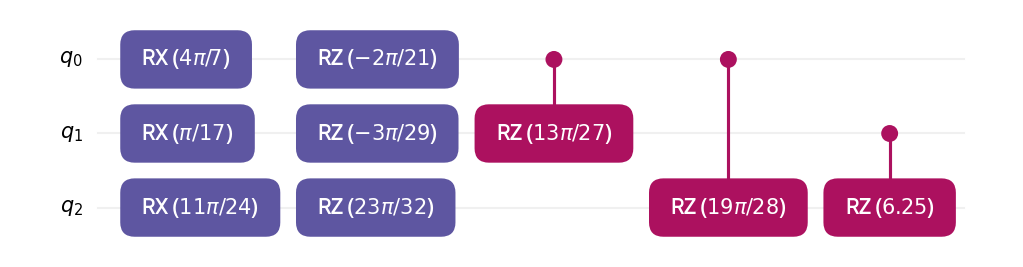

In [132]:
circuit = VQE.build_ansatz_circuit(np.array(res.x), nqubits, layers, connectivity)
circuit_simulation = backend.execute(functional=Sampling(circuit, nshots = 10000))
loss = classical_fidelity(analog_probabilities, circuit_simulation.probabilities)

print(loss)

circuit.draw()